In [1]:
pip install numpy scipy tensorflow scikit-learn matplotlib wfdb


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: /srv/jupyter/python-venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install wfdb


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import os

# List all files in the '/mit-bih-arrhythmia-database-1.0.0' directory
directory = 'mit-bih-arrhythmia-database-1.0.0'
files_in_directory = os.listdir(directory)

# Print out the list of files
for file in files_in_directory:
    print(file)


215.xws
109.atr
107.dat
230.xws
208.dat
111.hea
115.atr
ANNOTATORS
222.at_
124.atr
219.xws
104.dat
113.dat
119.at_
228.atr
207.dat
202.xws
200.atr
124.xws
111.xws
232.hea
122.hea
122.atr
117.xws
202.dat
100.xws
111.atr
213.atr
231.atr
214.at_
201.xws
209.hea
233.hea
209.at_
103.atr
112.dat
SHA256SUMS.txt
123.hea
119.dat
233.xws
214.dat
221.hea
228.xws
201.atr
101.hea
213.xws
223.atr
217.atr
219.hea
116.xws
117.at_
119.atr
220.hea
123.xws
119.hea
103.dat
207.atr
122.xws
102.hea
107.atr
212.hea
233.dat
123.atr
212.atr
113.hea
101.dat
212.dat
232.xws
108.dat
118.hea
232.dat
222.xws
231.xws
232.atr
207.hea
122.dat
105.atr
102.atr
215.at_
200.xws
231.dat
203.at_
222.dat
230.hea
115.dat
228.dat
118.xws
230.dat
203.at-
220.dat
234.dat
114.dat
106.hea
108.at_
201.hea
205.atr
202.hea
104.hea
220.atr
114.hea
108.xws
124.dat
205.hea
223.xws
200.hea
215.atr
233.atr
201.dat
117.hea
113.atr
114.atr
121.dat
103.xws
209.dat
107.xws
116.hea
116.dat
210.dat
223.hea
208.xws
214.hea
102.xws
101.atr
210.xw

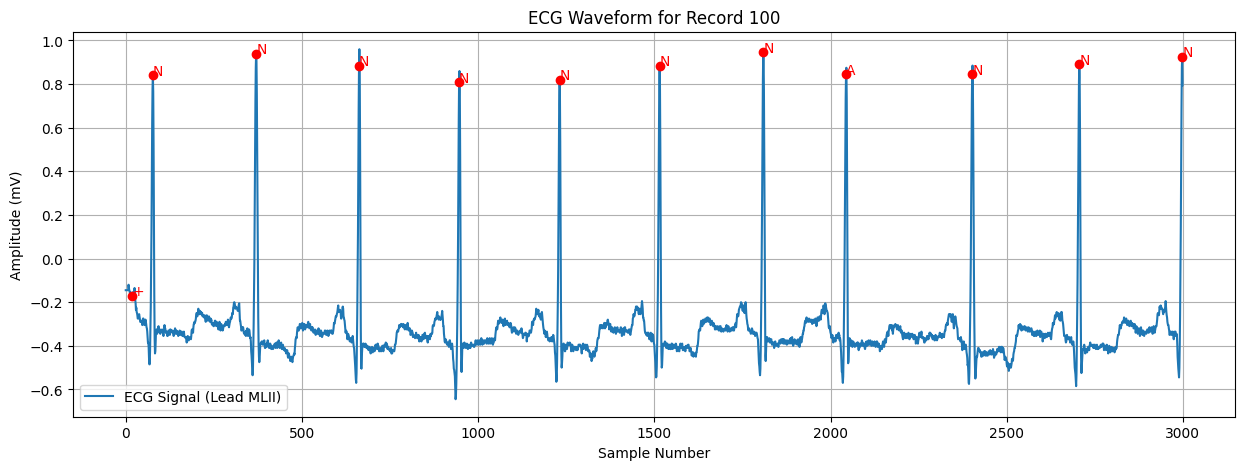

In [4]:
import wfdb
import matplotlib.pyplot as plt
import os

# Directory where the dataset is extracted
mit_bih_dir = 'mit-bih-arrhythmia-database-1.0.0'
# Select a record to visualize
record_name = '100'  # Change this to any record number you want to view
record_path = os.path.join(mit_bih_dir, record_name)

# Load the ECG signal and annotations
record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, 'atr')

# Plot the first 3000 samples from channel 0 (usually the MLII lead)
plt.figure(figsize=(15, 5))
plt.plot(record.p_signal[:3000, 0], label='ECG Signal (Lead MLII)')
plt.title(f'ECG Waveform for Record {record_name}')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude (mV)')

# Overlay annotations on the waveform
for idx, ann in enumerate(annotation.sample):
    if ann < 3000:  # Only show annotations in the plotted range
        plt.plot(ann, record.p_signal[ann, 0], 'ro')  # Mark annotation points
        plt.text(ann, record.p_signal[ann, 0], annotation.symbol[idx], color='red')

plt.legend()
plt.grid(True)
plt.show()


In [5]:
!pip install nvidia-pyindex
!pip install nvidia-cudnn-cu11


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
import numpy as np
import wfdb
from wfdb import rdann
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Directory where the dataset is extracted
mit_bih_dir = 'mit-bih-arrhythmia-database-1.0.0'

# Parameters
window_size = 200  # 200 samples before and after the beat
record_numbers = list(range(100, 235))
record_names = [str(num) for num in record_numbers]
selected_classes = ['N', 'L', 'R', 'A', 'V', 'F', '/', 'Q', 'e', 'j', 'E', 'S', 'J', 'a', 'f', 'Q', '?']  # Modify as needed
#These symbols correspond to a wide variety of cardiac events and arrhythmias, including:
#N: Normal beat
#L: Left bundle branch block
#R: Right bundle branch block
#A: Atrial premature contraction
#V: Ventricular premature contraction
#F: Fusion of ventricular and normal beat
#S: Supraventricular premature beat
#e: Atrial escape beat
#j: Nodal (junctional) escape beat
#E: Ventricular escape beat
#J: Nodal (junctional) premature beat
#/: Paced
#Q: Unclassifiable
#?: Unknown and others

# Lists to hold data and labels
X = []
y = []

# Loop through all records
for record in record_names:
    record_path = f"{mit_bih_dir}/{record}"
    if os.path.exists(f"{record_path}.atr"):
        # Load ECG signal and annotations
        record_data = wfdb.rdrecord(record_path)
        annotation = rdann(record_path, 'atr')

        # Extract segments around each beat
        for idx, beat in enumerate(annotation.symbol):
            if beat in selected_classes:
                beat_loc = annotation.sample[idx]

                # Check segment boundaries
                start = beat_loc - window_size
                end = beat_loc + window_size

                if start >= 0 and end < len(record_data.p_signal):
                    segment = record_data.p_signal[start:end, 0]  # Using MLII channel
                    X.append(segment)
                    y.append(beat)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Encode labels as integers
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)

# Shuffle data
X, y = shuffle(X, y, random_state=42)

# Normalize data
X = (X - np.mean(X)) / np.std(X)

# Reshape for CNN+LSTM input: (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Data Shape:", X.shape)
print("Label Shape:", y.shape)


2025-03-01 02:26:09.952229: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 02:26:09.979345: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 02:26:10.095851: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 02:26:10.137530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740795970.187191 3201943 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740795970.19

Data Shape: (109430, 400, 1)
Label Shape: (109430, 15)


In [7]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Define the model
model = Sequential()

# CNN Layers
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(100, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM Layers (Use Standard LSTM Instead of CuDNN)
model.add(LSTM(100, return_sequences=True, recurrent_activation='sigmoid'))
model.add(LSTM(100, recurrent_activation='sigmoid'))

# Fully Connected Layers
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(15, activation='softmax'))  # Adjust output classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/home/u562f9bff0c1c37ba6b72856ece14c08/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-01 02:26:21.953247: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 96, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 44, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 22, 100)        │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,511 (658.25 KB)

 Trainable params: 168,511 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
!pip install openvino

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [9]:
# Install openvino package
%pip install -q "openvino>=2023.1.0" opencv-python tqdm "matplotlib>=3.4" requests 


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: /srv/jupyter/python-venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from pathlib import Path

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, device_widget
device = device_widget()
device

<frozen importlib.util>:247: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.


Dropdown(description='Device:', index=9, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'GPU.3', 'GPU.4', 'GPU.5',…

In [11]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/20
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 249s 90ms/step - accuracy: 0.7815 - loss: 0.8017 - val_accuracy: 0.9248 - val_loss: 0.2901
Epoch 2/20
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 249s 91ms/step - accuracy: 0.9466 - loss: 0.2047 - val_accuracy: 0.9536 - val_loss: 0.1762
Epoch 3/20
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 249s 91ms/step - accuracy: 0.9643 - loss: 0.1394 - val_accuracy: 0.9611 - val_loss: 0.1523
Epoch 4/20
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 250s 91ms/step - accuracy: 0.9705 - loss: 0.1133 - val_accuracy: 0.9694 - val_loss: 0.1088
Epoch 5/20
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 257s 94ms/step - accuracy: 0.9742 - loss: 0.1002 - val_accuracy: 0.9761 - val_loss: 0.0857
Epoch 6/20
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 264s 97ms/step - accuracy: 0.9788 - loss: 0.0791 - val_accuracy: 0.9757 - val_loss: 0.0905
Epoch 7/20
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 264s 96ms/step - accuracy: 0.9803 - loss: 0.0727 - val_accuracy: 0.9771 - val_loss: 0.0868
Epoch 8/20
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 263s 96ms/step - accuracy: 

684/684 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.9867 - loss: 0.0500
Validation Accuracy: 0.9876633286476135


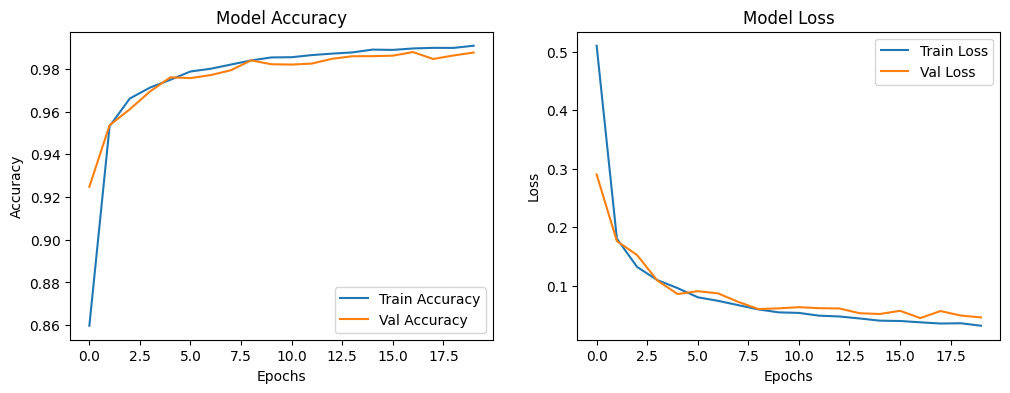

684/684 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step
Classification Report:
              precision    recall  f1-score   support

           /       1.00      0.99      1.00      1395
           A       0.94      0.90      0.92       525
           E       0.91      1.00      0.95        21
           F       0.81      0.82      0.81       169
           J       1.00      0.43      0.60        14
           L       1.00      0.99      0.99      1626
           N       0.99      0.99      0.99     14944
           Q       1.00      0.11      0.20         9
           R       0.99      1.00      0.99      1488
           V       0.97      0.98      0.97      1412
           a       0.71      0.83      0.76        35
           e       1.00      0.25      0.40         4
           f       0.94      0.97      0.96       197
           j       0.88      0.74      0.80        47

    accuracy                           0.99     21886
   macro avg       0.94      0.79      0.81     21886
weighted avg  

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion Matrix and Classification Report
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Get unique classes from the predictions
unique_classes = np.unique(y_pred_classes)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, labels=unique_classes, target_names=le.classes_[unique_classes]))
